<a href="https://colab.research.google.com/github/waltherwj/MGC_classifier/blob/main/Create_Data_MGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install hyppo

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for hyppo: filename=hyppo-0.2.1-cp37-none-any.whl size=98836 sha256=ffe896de9a604d036ba20d391142d340430e32e4f8a7e7821f628e7e30c58429
  Stored in directory: /root/.cache/pip/wheels/ea/ea/b1/df7c33975256fd60ab8abfc467fcc0247e66a2a7cff3e2d933
Successfully built hyppo


In [4]:
#imports
from scipy.stats import multiscale_graphcorr as MGC
import scipy
import numpy as np
import torch
import matplotlib.pyplot as plt
from inspect import getmembers
import inspect
import warnings
import hyppo

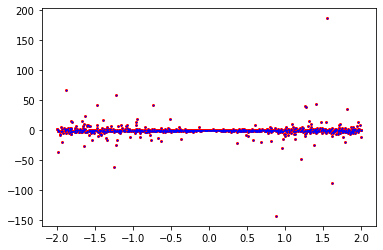

In [ ]:
x_test = (-2-2)*np.random.random(1000)+2
#x_test = np.sort(x_test)
y_test = (-2-2)*np.random.random(1000)+2

#plt.ylim(0,30)
plt.plot(x_test, np.true_divide(x_test,y_test), 'ro', markersize = 2)
plt.plot(x_test, np.divide(x_test,y_test), 'b+', markersize = 1)


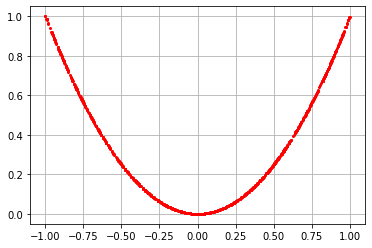

In [ ]:
x_test = (-1-1)*np.random.random(1000)+1
x_test[0]=-1
#x_test = np.sort(x_test)
y_test = np.square(x_test)
plt.plot(x_test, y_test, 'ro', markersize = 2)
plt.grid()

https://stackoverflow.com/questions/43729052/generator-function-yield-much-faster-then-iterator-class-next
Explains what type of function/generator to use for performance

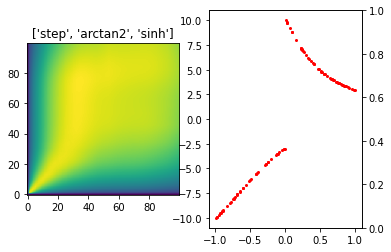

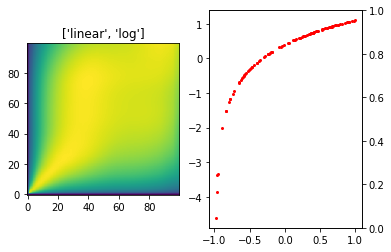

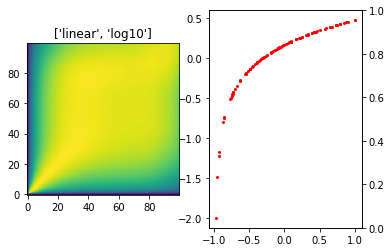

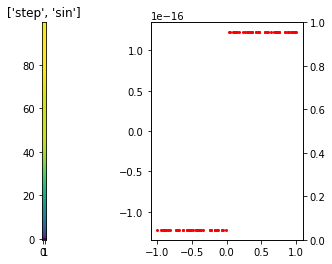

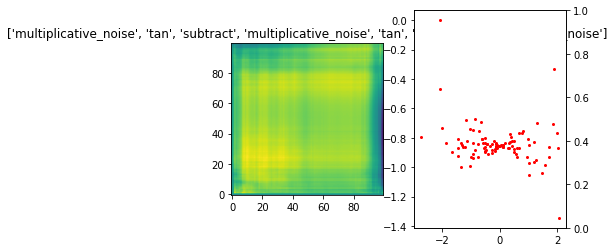

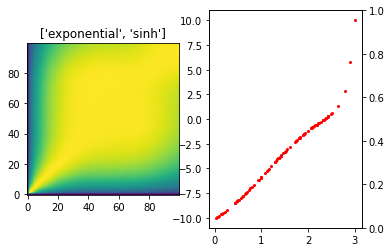

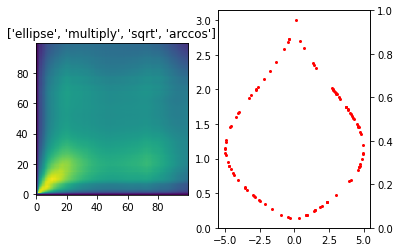

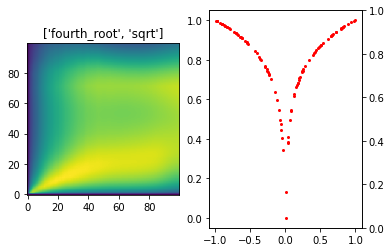

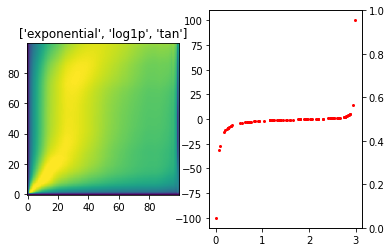

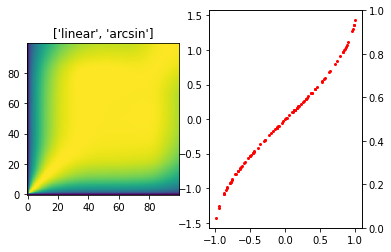

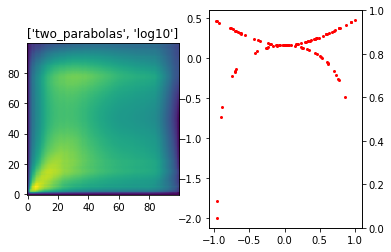

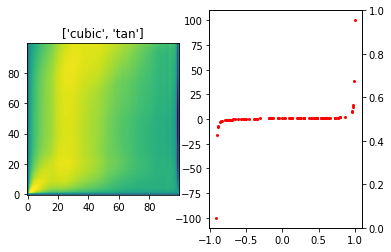

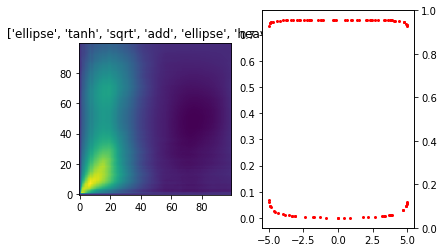

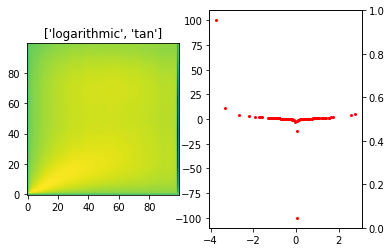

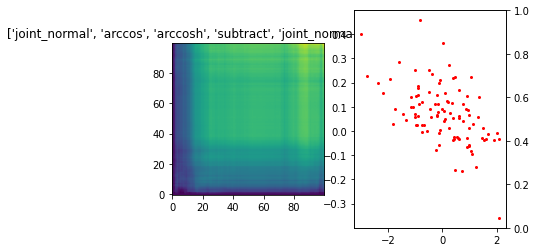

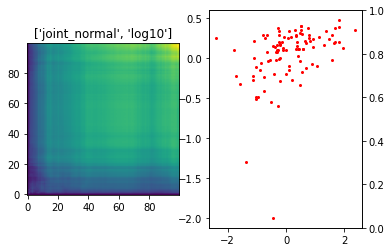

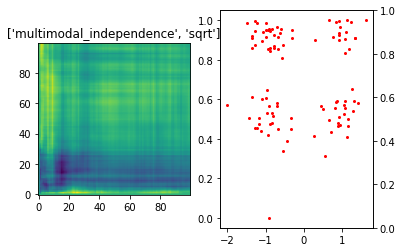

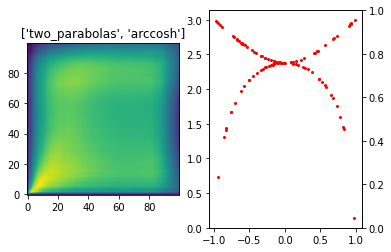

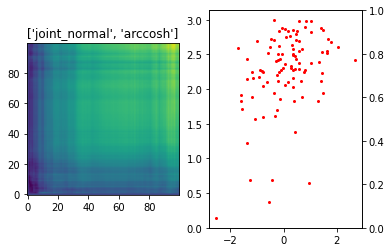

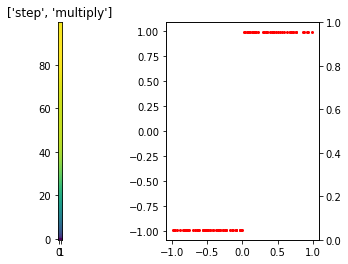

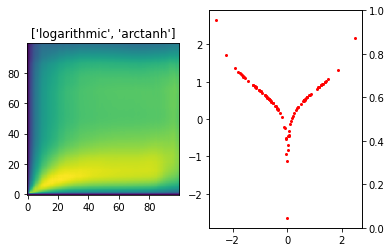

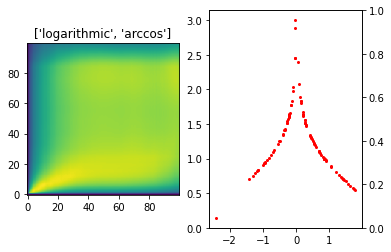

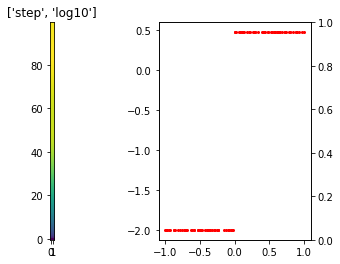

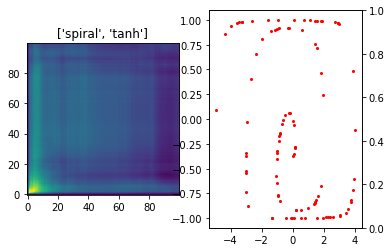

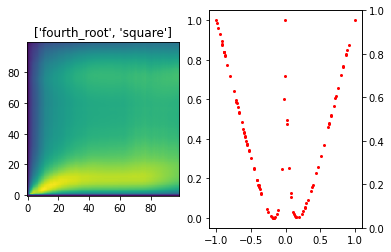

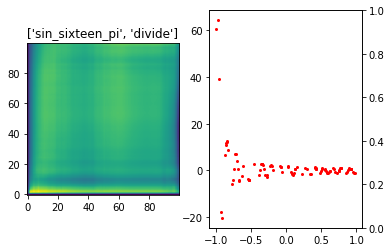

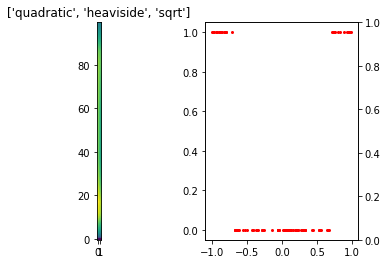

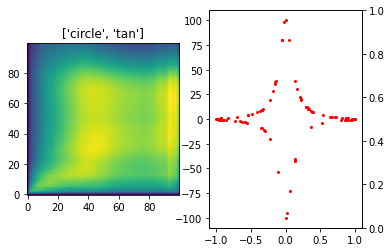

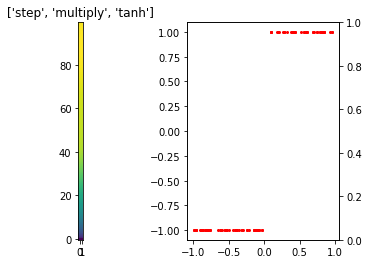

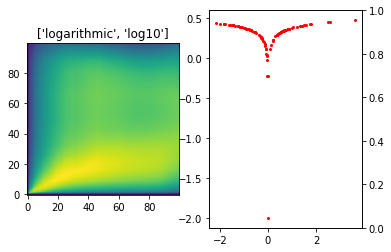

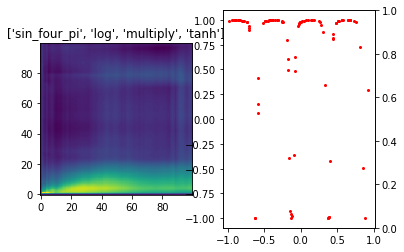

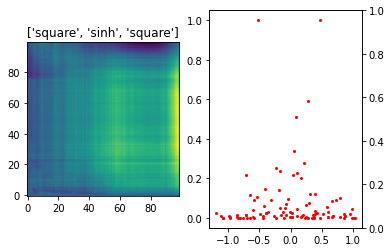

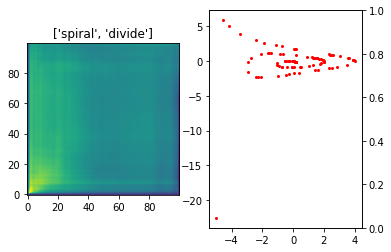

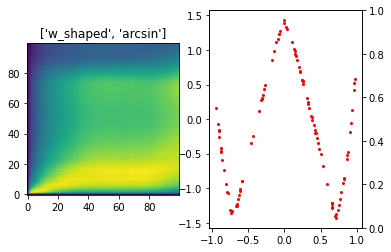

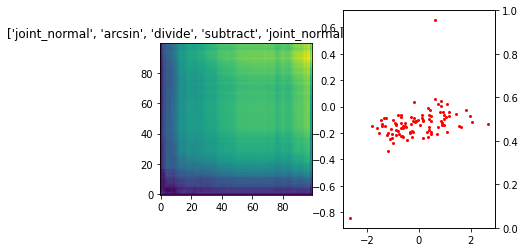

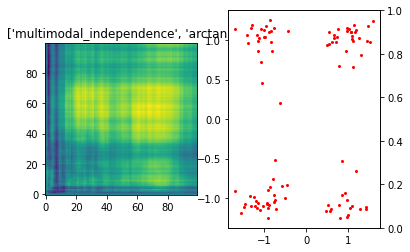

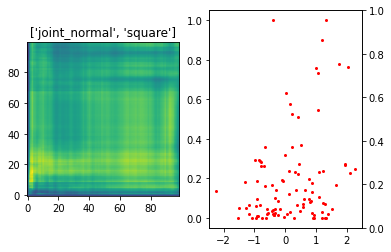

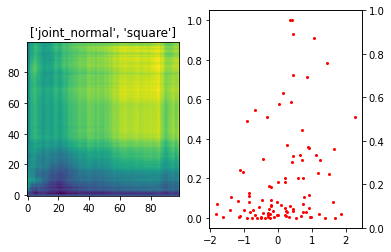

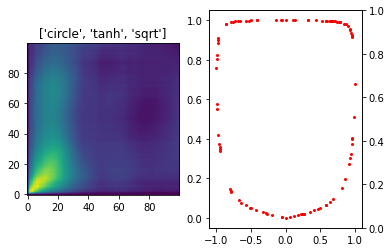

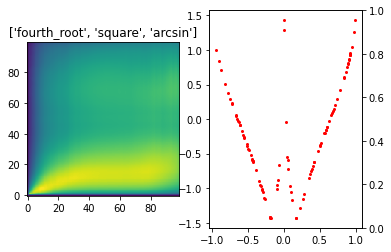

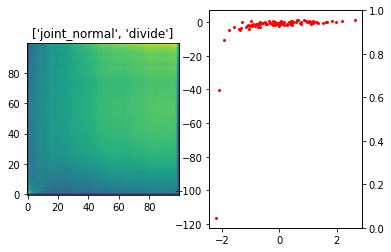

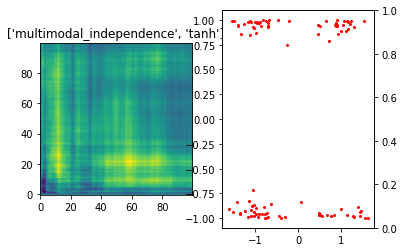

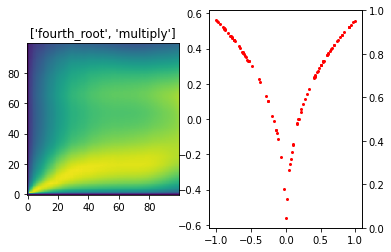

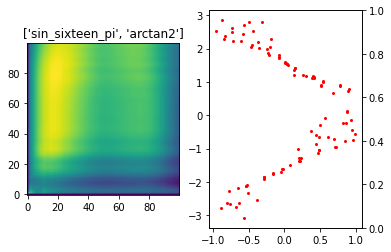

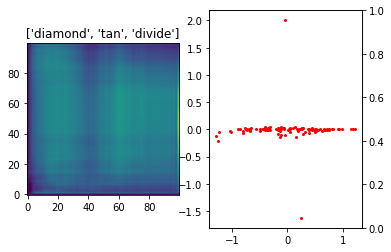

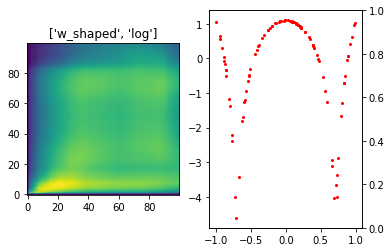

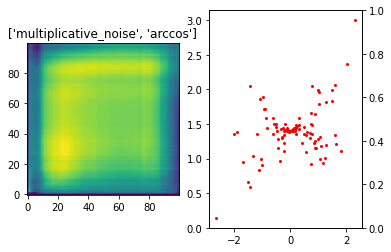

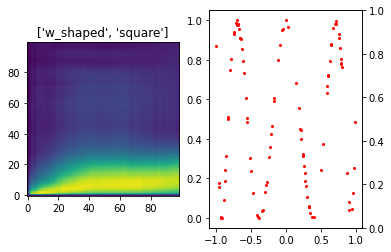

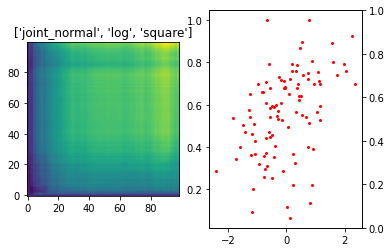

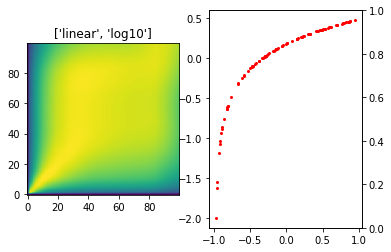

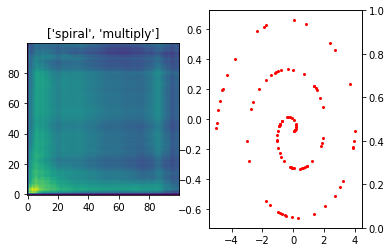

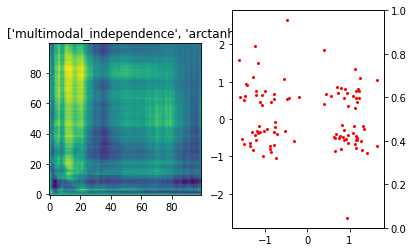

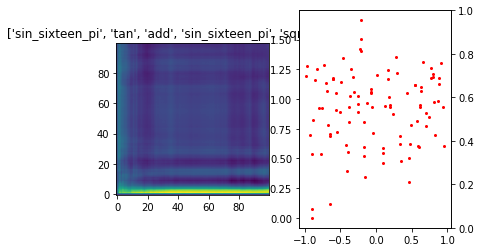

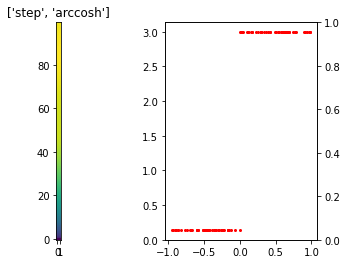

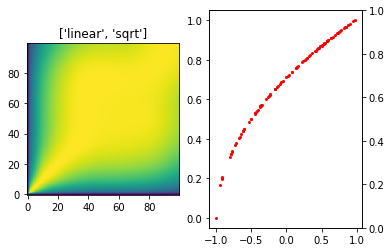

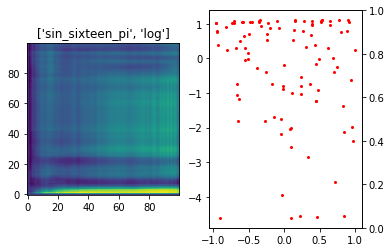

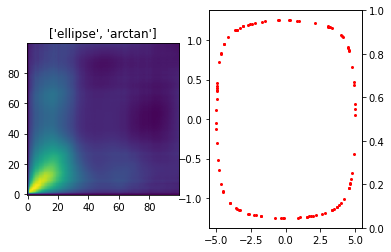

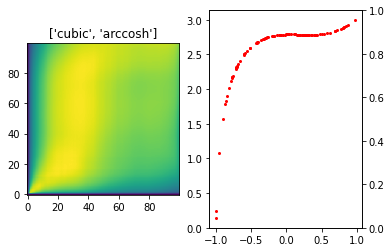

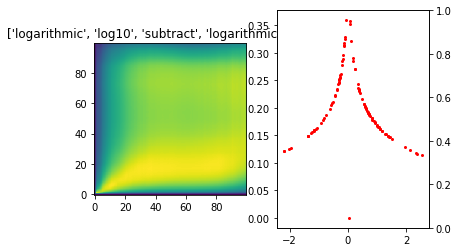

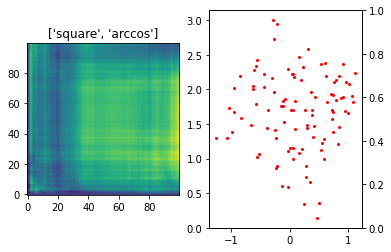

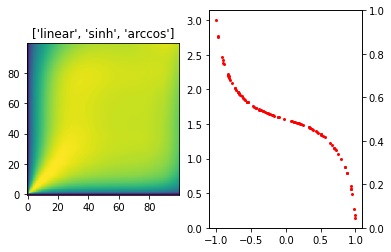

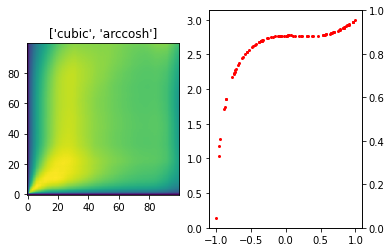

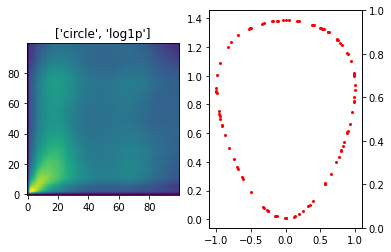

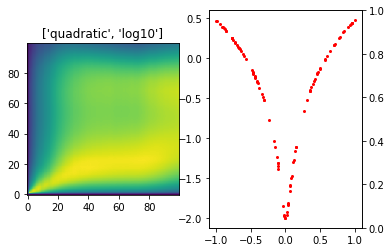

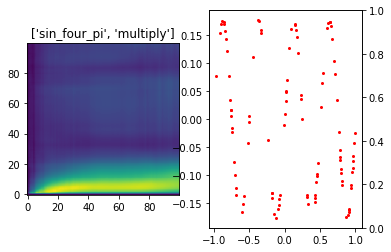

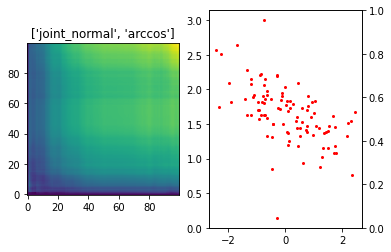

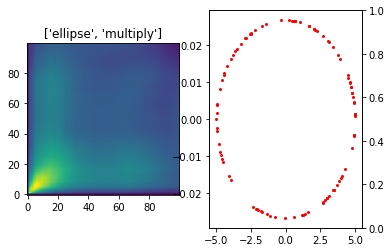

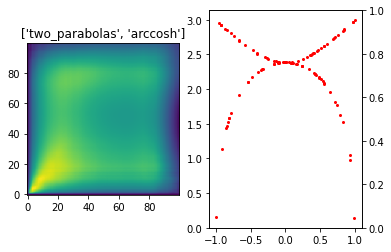

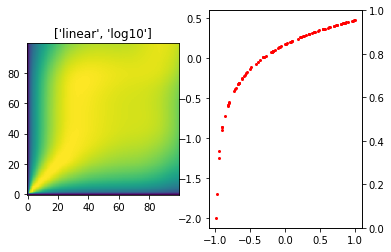

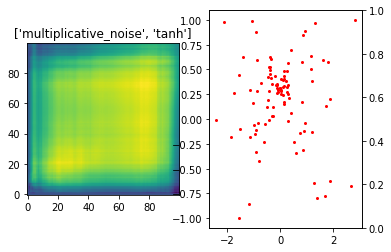

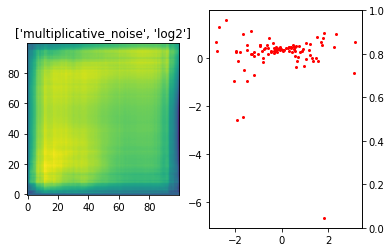

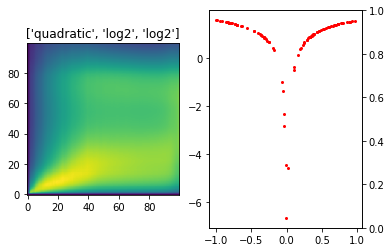

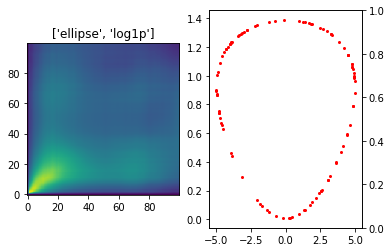

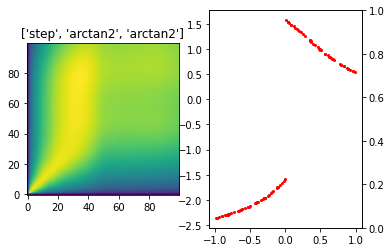

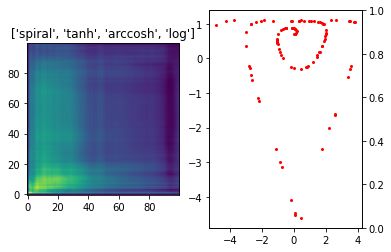

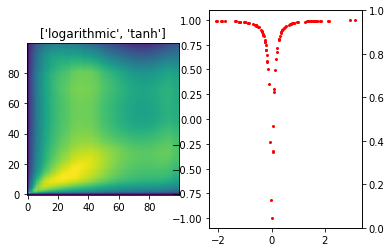

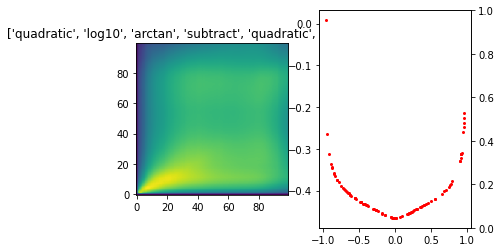

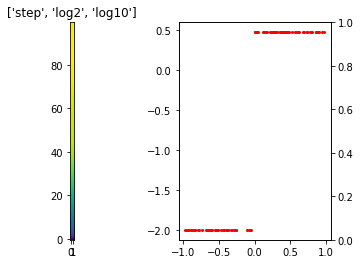

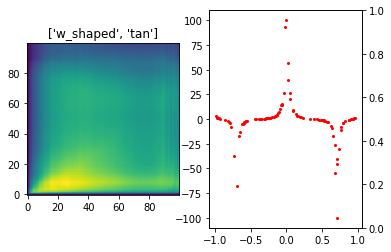

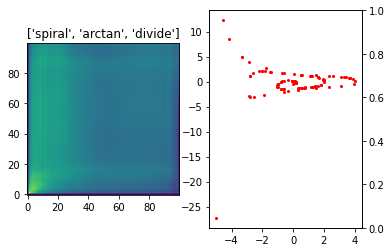

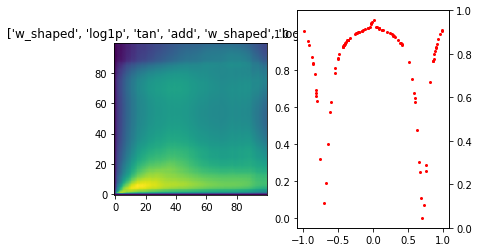

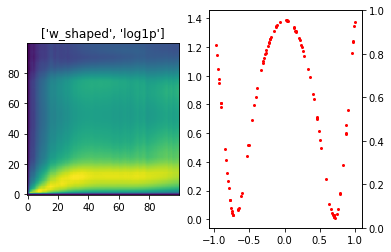

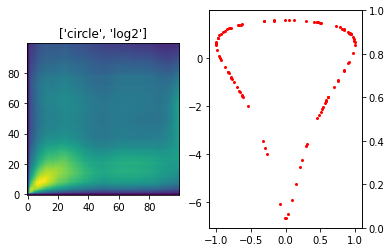

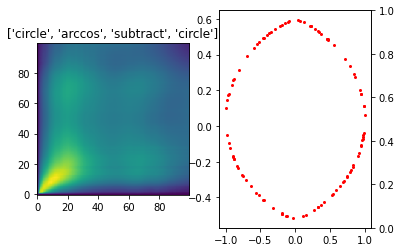

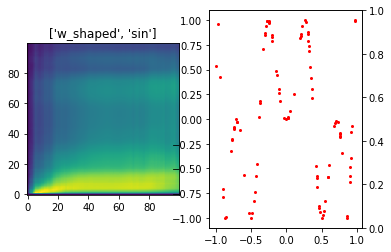

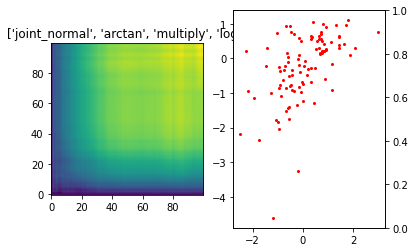

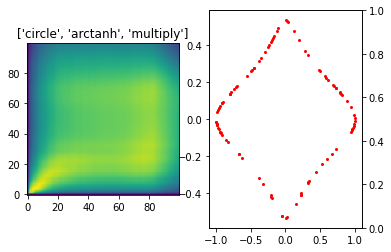

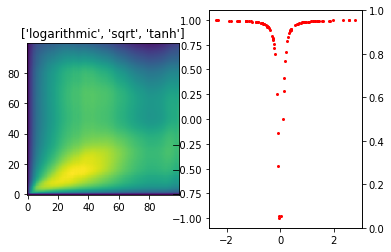

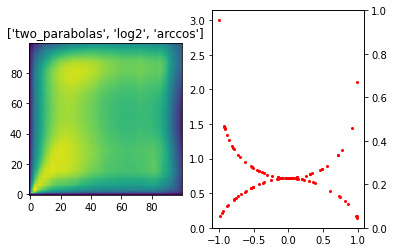

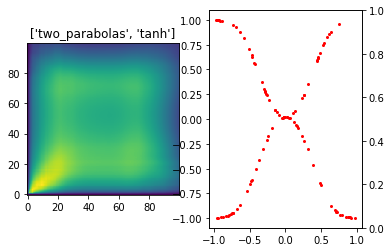

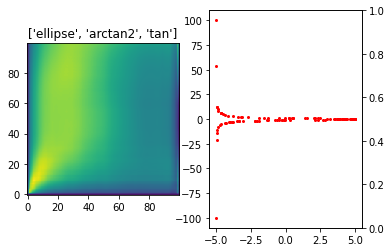

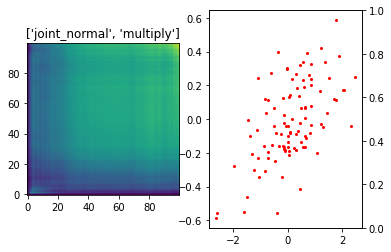

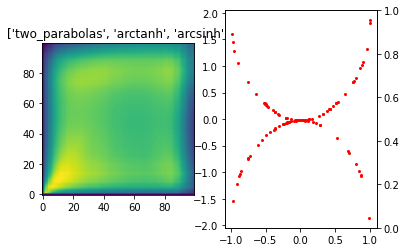

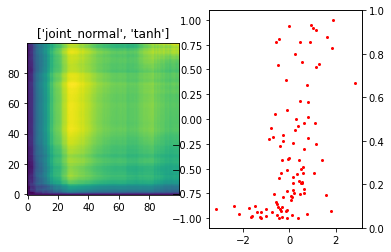

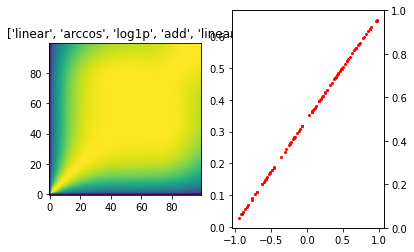

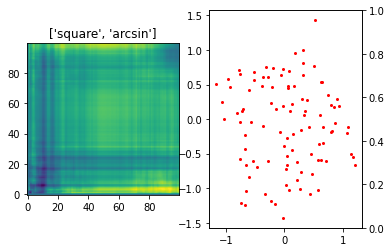

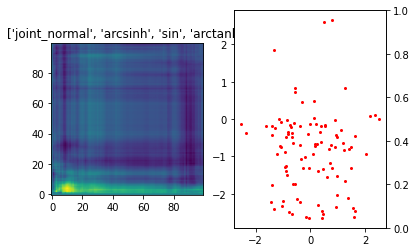

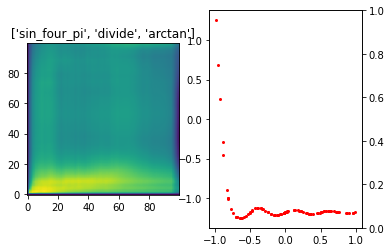

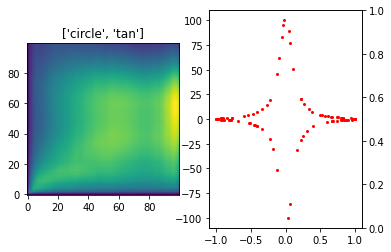

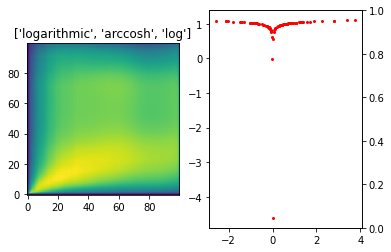

In [5]:

class function_generator():
  def __init__(self, sample_size=100):

    self.operations = ["arccos","arccosh","arcsin","arcsinh","arctan","arctan2",
                       "arctanh","heaviside","log","log10","log1p","log2",
                       "multiply","sin","sinh","sqrt","square","tan",
                       "tanh","divide", 'add', 'subtract']

    # one term operations
    self.one_term_operations = ["arccos","arccosh","arcsin","arcsinh","arctan",
                                "arctanh","log","log10","log1p","log2","sin",
                                "sinh","sqrt","square","tan","tanh"]

    self.hyppo_functions= ["linear","exponential","cubic", "joint_normal",
                "step","quadratic", "w_shaped", "spiral",
                "logarithmic", "fourth_root", "sin_four_pi", "sin_sixteen_pi",
                "square", "two_parabolas", "circle", "ellipse", "diamond",
                "multiplicative_noise", "multimodal_independence"]

    # two term operations
    self.two_term_operations = ["arctan2", "heaviside", "multiply",
                                "divide"]

    

    # TODO adding and subtracting new terms
    self.add_term_operations = ["add", "subtract"]

    # check if all operations are contained in the other sets
    assert (set(self.one_term_operations).union(set(self.two_term_operations)).
            union(set(self.add_term_operations)) == set(self.operations))
    
    self.sample_size = sample_size

    self.operation_scale_dict = {"arccos":  (-0.99,0.99),
                                  "arccosh": (1.01,10),
                                  "arcsin":  (-0.99,0.99),
                                  "arcsinh": (-np.pi,np.pi),
                                  "arctan":  (-3,3),
                                  "arctan2": ((-0.99,0.99),(-0.99,0.99)),
                                  "arctanh": (-0.99,0.99),
                                  "heaviside": ((-0.99,0.99),(-0.99,0.99)),
                                  "log": (0.01, 3),
                                  "log10": (0.01, 3),
                                  "log1p": (0.01, 3),
                                  "log2": (0.01, 3),
                                  "multiply": ((-1,1), (-1,1)),
                                  "sin": (-np.pi,np.pi),
                                  "sinh": (-3,3),
                                  "sqrt": (0,1),
                                  "square": (-1,1),
                                  "tan": (-np.pi/2+0.01, np.pi/2-0.01),
                                  "tanh":(-np.pi, np.pi),
                                  "divide": ((-2,2),(0.01,2)),
                                  "subtract": (-1,1),
                                  "add": (-1,1)}

    self.samples_dict = {}


  def yield_sample(self):
    """calls the other methods to yield samples lazily"""
    while True:

      # initialize the y_prev and x
      init_operator = np.random.choice(self.hyppo_functions)
      x, y_init = getattr(hyppo.tools, init_operator)(self.sample_size, 1)
      y_prev=y_init
      # store the operations for targets
      order_of_operations=[init_operator]

      #initialize a list for the terms
      terms = []

      # this controls how many successive operations are likely to happen
      rand=np.random.random()
      operation_count = 0
      while rand > 0.6 or len(order_of_operations)<2:
        # see if we add a new operation after this one
        rand = np.random.random()
        # get a random operator from the possible operators
        # and append it to a list that can be used as category targets
        # later
        operator = np.random.choice(self.operations)
        # increase the likelihood of creating a new term if there are already
        # a lot of operations, reset to zero if a new term has just been created
        if operation_count*(rand**2) > rand or operation_count>2:
          operator = np.random.choice(self.add_term_operations)

        operation_count +=1

        # get the actual function with this operator
        funct = getattr(np, operator)

        # TODO scale y_prev based on range that creates a representative shape 
        # of the selected function
        scale = self.operation_scale_dict[operator]
        if operator in self.one_term_operations:
          order_of_operations.append(operator)
          low = scale[0]
          high = scale[1]
          
          # scale to 0-1
          y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())
          # scale to new scale
          y_prev = y_prev*(high-low) + low
          
          #update the result and y_prev for the next operation
          y = funct(y_prev)
          y_prev = y

          

        elif operator in self.two_term_operations:
          order_of_operations.append(operator)

          # y_prev
          low_y, high_y= scale[0]
          # scale to 0-1
          y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())
          # scale to new scale
          y_prev = y_prev*(high_y-low_y) + low_y

          # y_temp
          low_x, high_x= scale[1]
          # scale to 0-1
          x_temp = (x - x.min()) /(x.max() - x.min())
          # scale to new scale
          x_temp = x_temp*(high_x-low_x) + low_x

          if operator == 'multiply':
            x_temp = np.ones_like(x_temp)*np.random.random()

          #update the result and y_prev for the next operation
          y = funct(y_prev, x_temp)
          y_prev = y

        elif operator in self.add_term_operations and operation_count>1:
          # append operation
          order_of_operations.append(operator)
          terms.append(y_prev)

          # reset y_prev for a new term
          y_prev = y_init
          order_of_operations.append(init_operator)
          operation_count=0
          # still have to actually perform the operation. Addition and subtraction happen later

        elif operator in self.add_term_operations and operation_count<=1:
          rand=1
      
      y=y_prev
      #append the last term
      terms.append(y)
      if len(terms)>1:
        # get the order of operation
        term_operators = [operator for operator in order_of_operations if (operator in self.add_term_operations)]
        
        self.terms = terms
        
        # scale all terms
        for i, term in enumerate(terms):
          term = np.array(term)
          term = ((term - term.min())/(term.max()-term.min()))*np.random.random()
          terms[i] = term
        
        y_temp = terms[0]
        for i, operator in enumerate(term_operators):
          # get the function with this operator
          funct = getattr(np, operator)
          term_after = terms[i+1]
          y_temp = funct(y_temp, term_after)

        # plt.plot(x, np.array(terms).T)
        
        y=y_temp
      # plt.plot(x, y, 'ro', markersize=2)
      # plt.pause(0.001)
      

      yield (x, y), order_of_operations

  def generate_MGC_maps(self, n_samples):

    # instantiate the generator
    gen = self.yield_sample()


    labels = []
    # generate the data
    for i in range(n_samples):
      #print(i)
      (x, y), label = next(gen)
      labels.append(label)
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
          _,_,MGC_DICT = MGC(x,y, reps=0)
          fig, axs = plt.subplots(1,2)
          axs[0].imshow(MGC_DICT["mgc_map"])
          axs[0].set_title(label)
          axs[0].invert_yaxis()
          axs[1].twinx()
          axs[1].plot(x, y, 'ro', markersize=2)
          plt.pause(0.001)
          self.samples_dict[i] = (MGC_DICT['mgc_map'], (x,y), label)
          
        except IndexError:
          pass




class_instance = function_generator(100)
generator = class_instance.yield_sample()
class_instance.generate_MGC_maps(100)



In [ ]:

class function_generator():
  def __init__(self, sample_size=100):



    self.hyppo_functions= ["linear","exponential","cubic", "joint_normal",
                "step","quadratic", "w_shaped", "spiral", "uncorrelated_bernoulli",
                "logarithmic", "fourth_root", "sin_four_pi", "sin_sixteen_pi",
                "square", "two_parabolas", "circle", "ellipse", "diamond",
                "multiplicative_noise", "multimodal_independence"]
    
    
    self.SIZE = sample_size


  def yield_sample(self):
    """calls the other methods to yield samples lazily"""
    while True:
      # get scaling factors randomly selected from an exponential distribution
      a = np.random.exponential()#scale = np.abs(np.random.random()))
      b = np.random.exponential()#scale = np.abs(np.random.random()))

      operator = np.random.choice(self.hyppo_functions)
      print(operator)

      funct = getattr(hyppo.tools, operator)

      if operator in ['multiplicative','multimodal_independence']:
        noise = False
      else:
        noise = False

      if operator in ["linear","exponential","cubic", "step","quadratic", 
                      "w_shaped", "spiral", "fourth_root", "sin_four_pi", 
                      "sin_sixteen_pi","square", "circle", 
                      "ellipse", "diamond"]:
        x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b))
      
      elif operator =="two_parabolas":
        x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b), 
                     prob=np.random.random())
        
      elif operator == 'uncorrelated_bernoulli':
        x, y = funct(self.SIZE,1, noise=noise, prob=np.random.random())

      elif operator in ["joint_normal", "logarithmic"]:
        x, y = funct(self.SIZE,1, noise=noise)
      
      elif operator == 'multimodal_independence':
        x, y = funct(self.SIZE,1, prob=np.random.random(), sep1=a, sep2=b)

      elif operator == 'multiplicative':
        x, y = funct(self.SIZE,1)

      yield (x, y), operator

  def generate_MGC_maps(self, n_samples):

    # instantiate the generator
    gen = self.yield_sample()


    labels = []
    # generate the data
    for i in range(n_samples):
      print(i)
      (x, y), label = next(gen)
      
      labels.append(label)
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _,_,MGC_DICT = MGC(x,y, reps=0)
        fig, axs = plt.subplots(1,2)
        axs[0].imshow(MGC_DICT["mgc_map"])
        axs[0].set_title(label)
        axs[0].invert_yaxis()
        axs[1].twinx()
        axs[1].plot(x, y, 'ro', markersize=2)
        plt.pause(0.001)




class_instance = function_generator(100)
generator = class_instance.yield_sample()
class_instance.generate_MGC_maps(100)

    # plt.title(order_of_operations)
    # stat, p_value, mgc_dict = MGC(x, y, reps=0)
    # plt.twinx().imshow(mgc_dict['mgc_map'], cmap='Purples')
    # plt.gca().invert_yaxis()
    # plt.plot(x,y, 'ro', markersize=2)
    # plt.pause(0.000000001)



0.4867827172013097
square
0.7871696835466937
square
0.5940196566066747
add
terms 1
0.6482973883105771
tanh
0.28446583917160795
log10
len terms 2
['add']


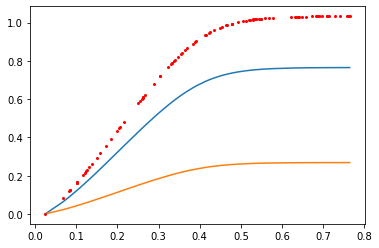

Text(0.5, 1.0, "['square', 'square', 'add', 'tanh', 'log10']")

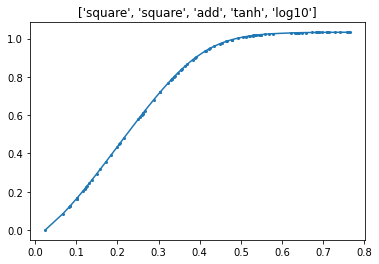

In [ ]:
(x_test, y_test), order = next(generator)
plt.plot(x_test, y_test, 'o-', markersize=2)
plt.title(order)